<a href="https://colab.research.google.com/github/elliotgengler/Option-DeAmericanization/blob/main/FirstPricer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

In [ ]:
def digits_right(guess,actual):
  return -math.log10(abs(guess-actual))

def print_eval(est,actual,start,stop,prec):
  print("Estimate:",round(est,prec))
  print("Error:",round(actual-est,prec))
  print("Digits Correct:",round(digits_right(est,actual),2))
  print("Time Elapsed (s):", round(stop-start,2))

# European Option Pricing

In [ ]:
def payoff(S_0,N,j,u,d,K,is_call):
  S_t = S_0 * u**j * d**(N-j) # up j times, down N-j times
  if is_call:
    return max(S_t-K,0)
  else:
    return max(K-S_t,0)

def p_riskneutral(r,q,delta_time,u,d):
  return (math.exp((r-q)*delta_time)-d)/(u-d)

def euro(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  sum = 0
  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  for j in range(N+1):
    sum += math.comb(N,j) * pstar**j * (1-pstar)**(N-j) * payoff(S_0,N,j,u,d,K,is_call) # probability times payoff

  return sum * math.exp(-r*Maturity)

In [ ]:
start = time.time()
est = euro(100,100,1,0.2,1000,0.05,0.02,True)
stop = time.time()
print_eval(est,9.2269939894,start,stop,6)

Estimate: 9.225062
Error: 0.001932
Digits Correct: 2.71
Time Elapsed (s): 0.05


In [ ]:
def backward_induce_euro(V,pstar,disc):
  U = np.zeros(V.shape[0]-1)
  for j in range(V.shape[0]-1):
    U[j] = (pstar*V[j+1] + (1-pstar)*V[j]) * disc
  return U

def euro_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  disc = math.exp(-r*Maturity/N)

  V = np.zeros(N+1)
  for i in range(N+1):
    V[i] = payoff(S_0,N,i,u,d,K,is_call)  # initialize payoff at maturity

  for i in range(N):
    V = backward_induce_euro(V,pstar,disc)
  return V[0]

In [ ]:
start = time.time()
est = euro_backward_induction(100,100,1,0.2,5000,0.05,0.02,True)
stop = time.time()

print_eval(est,9.2269939894,start,stop,6)

Estimate: 9.226617
Error: 0.000377
Digits Correct: 3.42
Time Elapsed (s): 12.96


## Convergence


In [ ]:
errors = []
times = []
for i in range(1,1001):
  start = time.time()
  errors.append(euro(100,100,1,0.2,i,0.05,0.02,True)-9.2269939894)
  stop = time.time()
  times.append(stop-start)

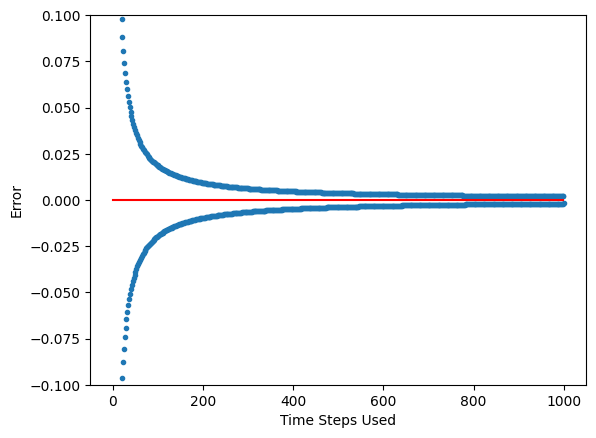

In [ ]:
plt.scatter(range(1,1001),errors,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

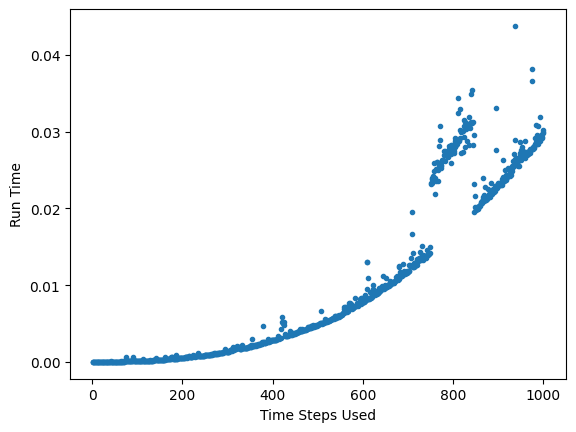

In [ ]:
plt.scatter(range(1,1001),times,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

## Averaging

In [ ]:
def euro_averager(S_0,K,Maturity,sigma,N,r,q,is_call):
  if N <= 1000: #when overflow isn't an issue, binomial coefficients are faster
    a = euro(S_0,K,Maturity,sigma,N,r,q,is_call)
    b = euro(S_0,K,Maturity,sigma,N+1,r,q,is_call)
    return (a+b)/2
  else:
    a=euro_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call)
    b=euro_backward_induction(S_0,K,Maturity,sigma,N+1,r,q,is_call)
    return (a+b)/2

In [ ]:
start = time.time()
est = euro_averager(100,100,1,0.2,5000,0.05,0.02,True)
stop = time.time()

print_eval(est,9.2269939894,start,stop,8)

Estimate: 9.22699569
Error: -1.7e-06
Digits Correct: 5.77
Time Elapsed (s): 17.47


In [ ]:
errors_avg = []
times_avg = []
for i in range(1,1001):
  start = time.time()
  errors_avg.append(euro_averager(100,100,1,0.2,i,0.05,0.02,True)-9.2269939894)
  stop = time.time()
  times_avg.append(stop-start)

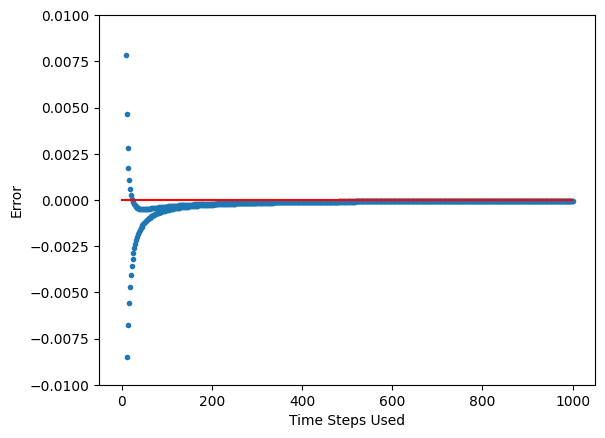

In [ ]:
plt.scatter(range(1,1001),errors_avg,marker='.')
plt.plot(np.zeros(1000),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.01,0.01]);

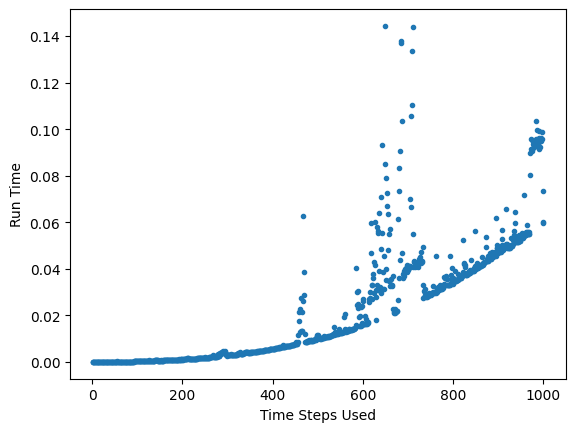

In [ ]:
plt.scatter(range(1,1001),times_avg,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

# American Options

In [ ]:
def backward_induce_american(V,S,u,pstar,disc,K,is_call):
  U = np.zeros(V.shape[0]-1) # vector of option prices, one time step back
  R = np.zeros(V.shape[0]-1) # vector of stock prices, one time step back

  for j in range(V.shape[0]-1):
    R[j] = S[j]*u # step the stocks backwards by multiplying by u

    continuing_val = pstar*V[j+1] + (1-pstar)*V[j]
    if is_call:
      exercise_val = max(R[j]-K,0)
    else:
      exercise_val = max(K-R[j],0)

    U[j] = max(continuing_val,exercise_val) * disc
  return U,R

In [ ]:
def american_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call):
  u = math.exp(sigma*math.sqrt(Maturity/N)) # CRR Assumptions
  d = math.exp(-sigma*math.sqrt(Maturity/N))

  pstar = p_riskneutral(r,q,Maturity/N,u,d) # risk neutral probability of up
  disc = math.exp(-r*Maturity/N)

  V = np.zeros(N+1)
  S = np.zeros(N+1)
  for i in range(N+1):
    V[i] = payoff(S_0,N,i,u,d,K,is_call)
    S[i] = S_0*u**(i)*d**(N-i)

  for i in range(N):
    V,S = backward_induce_american(V,S,u,pstar,disc,K,is_call)
  return V[0]

In [ ]:
start = time.time()
est = american_backward_induction(100,100,1,0.2,5000,0.05,0.02,False)
stop = time.time()

print_eval(est,6.66069,start,stop,6)

Estimate: 6.660436
Error: 0.000254
Digits Correct: 3.6
Time Elapsed (s): 21.79


# Convergence

In [ ]:
errors_am = []
times_am = []
for i in range(1,501):
  start = time.time()
  errors_am.append(american_backward_induction(100,100,1,0.2,i,0.05,0.02,False)-6.66069)
  stop = time.time()
  times_am.append(stop-start)

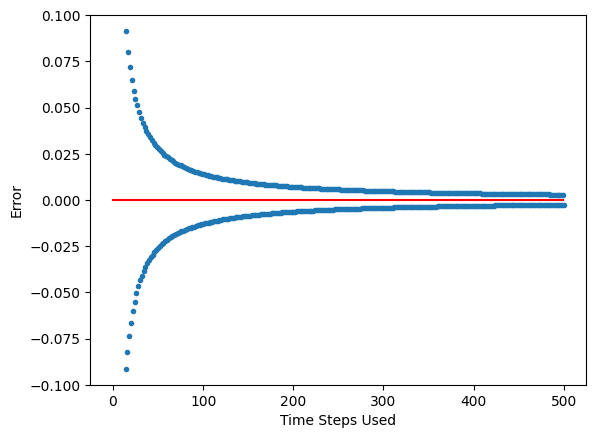

In [ ]:
plt.scatter(range(1,501),errors_am,marker='.')
plt.plot(np.zeros(500),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.1,0.1]);

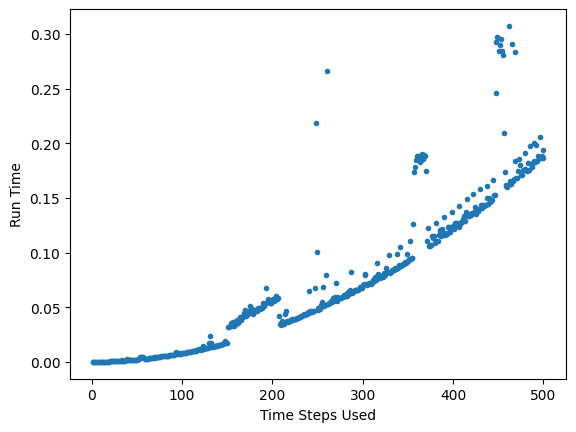

In [ ]:
plt.scatter(range(1,501),times_am,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");

## Averaging

In [ ]:
def american_averager(S_0,K,Maturity,sigma,N,r,q,is_call):
  a = american_backward_induction(S_0,K,Maturity,sigma,N,r,q,is_call)
  b = american_backward_induction(S_0,K,Maturity,sigma,N+1,r,q,is_call)
  avg = (a+b)/2
  return avg

In [ ]:
errors_amavg = []
times_amavg = []
for i in range(1,251):
  start = time.time()
  errors_amavg.append(american_averager(100,100,1,0.2,i,0.05,0.02,False)-6.66069)
  stop = time.time()
  times_amavg.append(stop-start)

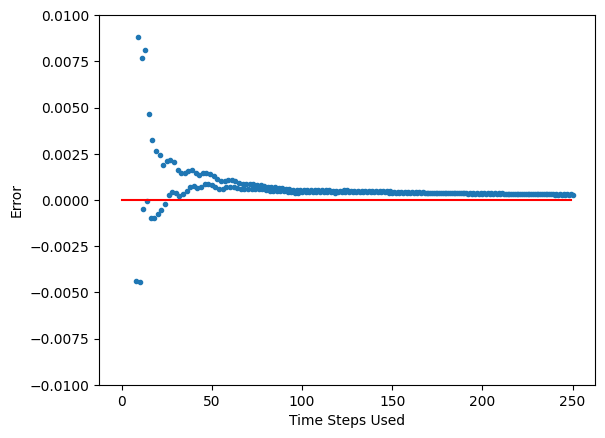

In [ ]:
plt.scatter(range(1,251),errors_amavg,marker='.')
plt.plot(np.zeros(250),color='red')
plt.xlabel("Time Steps Used")
plt.ylabel("Error");
plt.ylim([-0.01,0.01]);

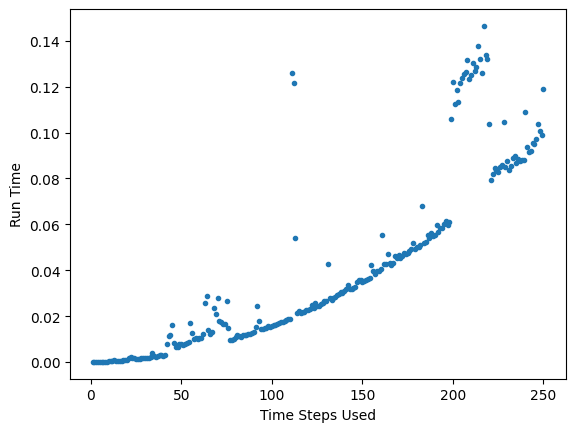

In [ ]:
plt.scatter(range(1,251),times_amavg,marker='.')
plt.xlabel("Time Steps Used")
plt.ylabel("Run Time");